In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# Get data
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

3670


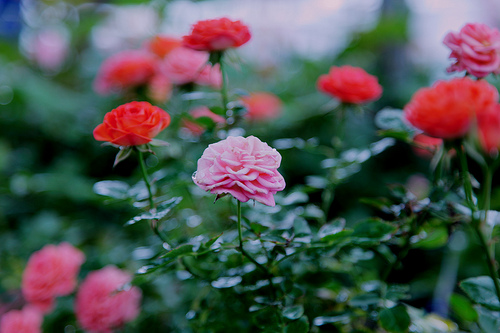

In [5]:
# Image count
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

# visualize 
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))
PIL.Image.open(str(roses[1]))

In [6]:
# Dataset creation
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


2022-07-11 11:27:41.553930: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022-07-11 11:27:54.678435: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


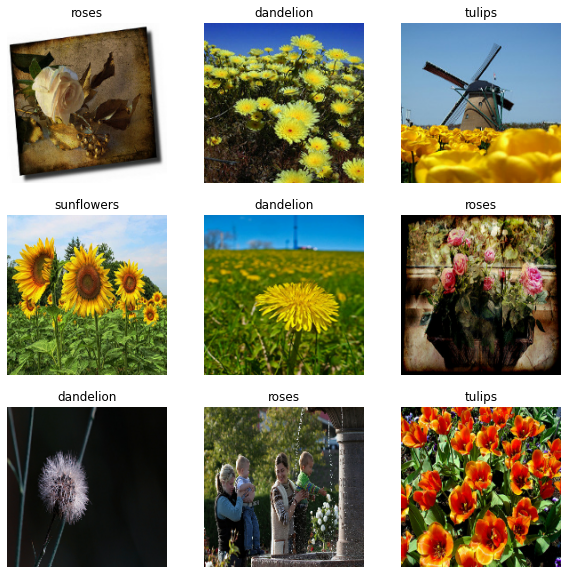

In [7]:
# Visualize data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
# Dataset shape
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [10]:
# performance enhancement
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
# Normalization layer 
normalization_layer = layers.Rescaling(1./255)

# apply view map
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# See results
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0034399498 1.0


In [13]:
# Create model 
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

In [14]:
# train
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 19s 205ms/step - loss: 1.2789 - accuracy: 0.4581 - val_loss: 1.0155 - val_accuracy: 0.5899
Epoch 2/10
92/92 [==============================] - 19s 205ms/step - loss: 0.9732 - accuracy: 0.6124 - val_loss: 0.9757 - val_accuracy: 0.6104
Epoch 3/10
92/92 [==============================] - 20s 216ms/step - loss: 0.7919 - accuracy: 0.6890 - val_loss: 0.9788 - val_accuracy: 0.6172
Epoch 4/10
92/92 [==============================] - 20s 214ms/step - loss: 0.5736 - accuracy: 0.7905 - val_loss: 0.9138 - val_accuracy: 0.6567
Epoch 5/10
92/92 [==============================] - 20s 214ms/step - loss: 0.3768 - accuracy: 0.8614 - val_loss: 0.9448 - val_accuracy: 0.6826
Epoch 6/10
92/92 [==============================] - 20s 215ms/step - loss: 0.2065 - accuracy: 0.9346 - val_loss: 1.1214 - val_accuracy: 0.6649
Epoch 7/10
92/92 [==============================] - 19s 210ms/step - loss: 0.1206 - accuracy: 0.9622 - val_loss: 1.4047 - val_accuracy: 0.6526

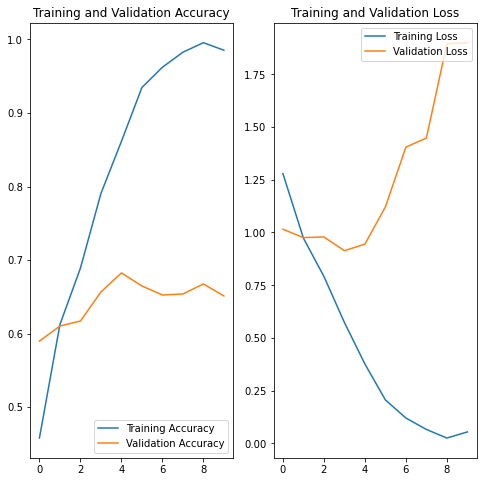

In [15]:
# Visualize training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Overfitting Countermeasures

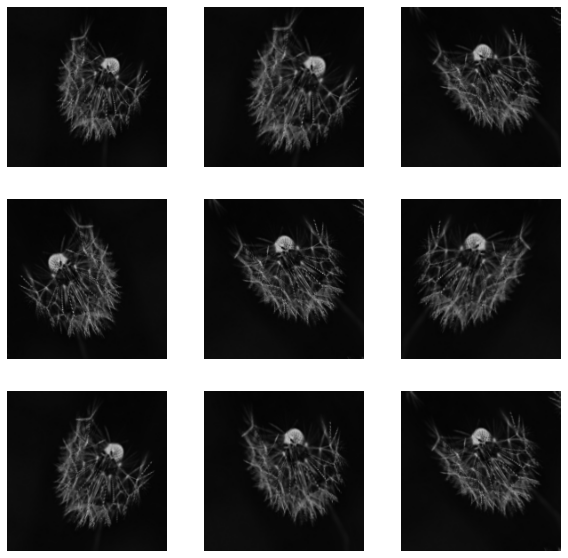

In [16]:
# Data augmentation 
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# visualize data augmentation 
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [17]:
# dropout + data augmentation in new model 
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

In [18]:
# train 
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 22s 234ms/step - loss: 1.3476 - accuracy: 0.4135 - val_loss: 1.1304 - val_accuracy: 0.5286
Epoch 2/15
92/92 [==============================] - 23s 250ms/step - loss: 1.0615 - accuracy: 0.5736 - val_loss: 1.0271 - val_accuracy: 0.5981
Epoch 3/15
92/92 [==============================] - 24s 263ms/step - loss: 0.9598 - accuracy: 0.6213 - val_loss: 0.9110 - val_accuracy: 0.6444
Epoch 4/15
92/92 [==============================] - 23s 247ms/step - loss: 0.8655 - accuracy: 0.6771 - val_loss: 0.8327 - val_accuracy: 0.6662
Epoch 5/15
92/92 [==============================] - 23s 247ms/step - loss: 0.8318 - accuracy: 0.6751 - val_loss: 0.9065 - val_accuracy: 0.6376
Epoch 6/15
92/92 [==============================] - 23s 245ms/step - loss: 0.8010 - accuracy: 0.6958 - val_loss: 0.8285 - val_accuracy: 0.6826
Epoch 7/15
92/92 [==============================] - 23s 247ms/step - loss: 0.7645 - accuracy: 0.7027 - val_loss: 0.7455 - val_accuracy: 0.7030

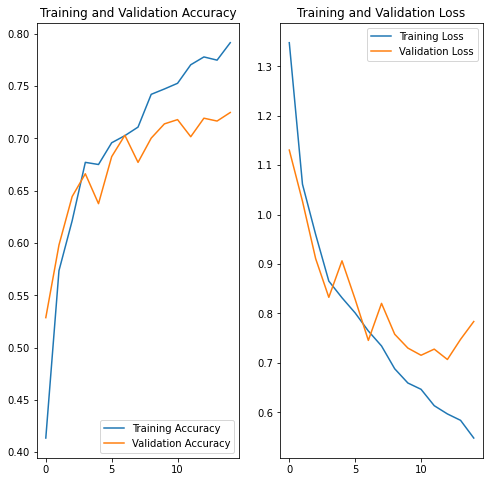

In [19]:
# visulaize training 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


This image most likely belongs to sunflowers with a 98.55 percent confidence.


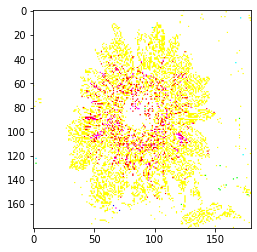

In [22]:
# Using model to predict new data 
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
plt.imshow(img_array[0])
plt.show()